In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import itertools


from iarchitect import envs,trainer as trainer_iarch
from iarchitect.agents import dqn as dqn_iarch
from iarchitect.common import show_policy_behaviour,create_policy_eval_video
from iarchitect.common.callbacks import output_updater,update_plotter,fig_trainer

from tf_agents.agents import DdpgAgent,DqnAgent,PPOAgent,PPOClipAgent
from tf_agents.agents.dqn.dqn_agent import DdqnAgent
from tf_agents.agents.ppo.ppo_actor_network import PPOActorNetwork
from tf_agents.networks.value_network import ValueNetwork
from tf_agents.networks.actor_distribution_network import ActorDistributionNetwork
from tf_agents.environments import ActionDiscretizeWrapper

from tf_agents.utils import common
from tf_agents import networks
from tf_agents.networks import sequential
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.metrics import py_metrics,tf_metrics
from tf_agents.drivers import py_driver,dynamic_episode_driver,dynamic_step_driver
from tf_agents.policies import random_py_policy,random_tf_policy,PyTFEagerPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer,py_uniform_replay_buffer

from tensorflow import Tensor,Variable
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras import initializers

2022-03-07 23:39:22.706634: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 23:39:22.706670: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
SOLUTION_NAME = "WindowEnvWhatPlantDDQN"

In [4]:
environment = envs.WindowEnv(16,np.fromiter(range(10),dtype=int),
                             render_dims=(4,4),max_species_reset=5,action_float=False,action_shape_one=False)
utils.validate_py_environment(environment, episodes=5)
train_env = tf_py_environment.TFPyEnvironment(environment)

In [5]:
train_env.action_spec()

BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(9))

In [6]:
def dense_layer(num_units):
    return layers.Dense(
        num_units,
        activation="relu",
        kernel_initializer=initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))
def network(fc_layers_units,dimension_q_values):
    q_values_layer = layers.Dense(
            dimension_q_values,
            activation=None,
            kernel_initializer=initializers.RandomUniform(
                minval=-0.03, maxval=0.03),
            bias_initializer=initializers.Constant(-0.2))
    return sequential.Sequential([layers.Flatten()] + [dense_layer(n) for n in fc_layers_units] + [q_values_layer])


In [7]:
#actor_net=ActorDistributionNetwork(train_env.observation_spec(),train_env.action_spec())
agent = DdqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        optimizer=Adam(learning_rate=0.0005),
        q_network=network((20,20),len(environment.tuiles)),
        )
agent.initialize()

2022-03-07 23:39:25.071522: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-07 23:39:25.071562: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-07 23:39:25.071577: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ALS-358): /proc/driver/nvidia/version does not exist
2022-03-07 23:39:25.071751: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
def plot_obs(obs,ax):
    return ax.imshow(obs,vmin=0.0,vmax=1.0)

def plot_traj(tr,ax):
    return ax.imshow(tr)

def evaluate_policy(each_step=1,n_epochs=5):
    def evaluate_(step,trainer):
        if step % each_step == 0:
            for _ in range(n_epochs):
                time_step = trainer.tf_env.reset()
                while not time_step.is_last():
                    print(trainer.tf_env.envs[0].render())
                    action_step = trainer.agent.policy.action(time_step)
                    time_step = trainer.tf_env.step(action_step.action)
                display(trainer.tf_env.envs[0].render())
                display("----------- end --------------")
    return evaluate_

In [9]:
trainer = trainer_iarch.Trainer(train_env,agent)
trainer.initialize_buffer(min_size=640,random_policy=False)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


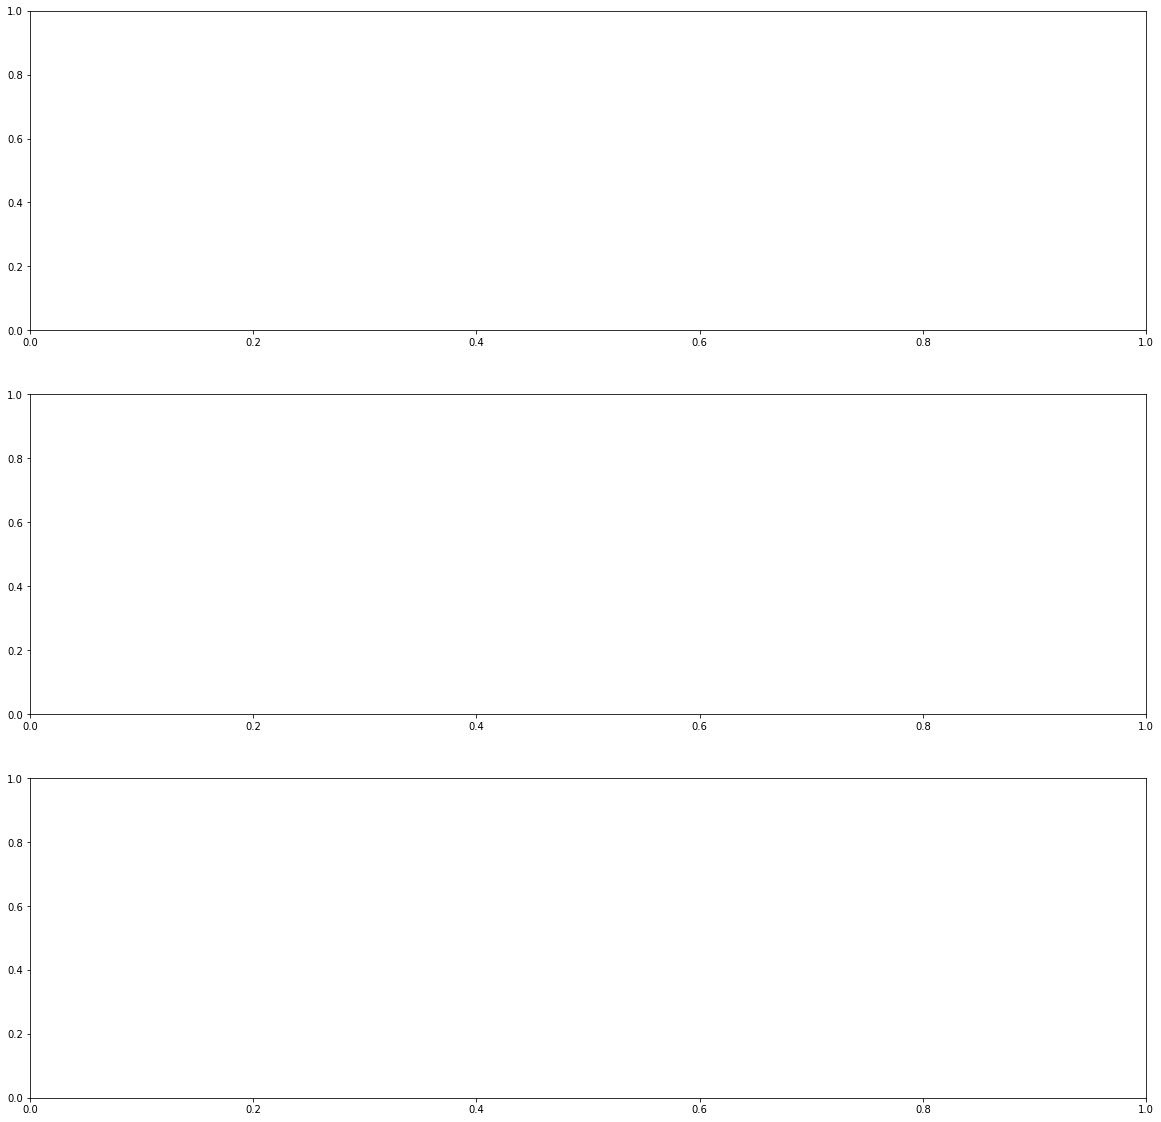

In [10]:
fig_tr = fig_trainer(3,1,figsize=(20,20))

callbacks = [update_plotter(fig_tr,plot_obs),
             output_updater(fig_tr,clear_output=False),
             evaluate_policy(n_epochs=5)
             ]

callbacks = []
trainer.run(callbacks=callbacks,
            buffer_size_increase_per_iteration = 10,
            sample_batch_size_experience = 64,
            num_iterations_train = 10,
            num_steps_per_row_in_experience = 2
           )

In [ ]:
fig_tr.savefig(SOLUTION_NAME+".png")

In [ ]:
trainer.tf_env.reset()
fig,ax = plt.subplots()
fig2,axes_ = plt.subplots(5,5)
trainer.evaluate_agent(50)
obs=trainer.observer.observations()[-25:]
trainer.observer.plot_reward(ax=ax,slice_=slice(-25,None,None))
for o,ax_ in zip(obs,fig2.axes):
    res = plot_obs(o,ax_)
res

In [99]:
create_policy_eval_video(train_env,environment,trainer.agent.policy,SOLUTION_NAME,num_episodes=10,fps=5)

In [100]:
create_policy_eval_video(train_env,environment,random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),train_env.action_spec()),SOLUTION_NAME + "_random",num_episodes=10,fps=5)

(288, 432, 4)

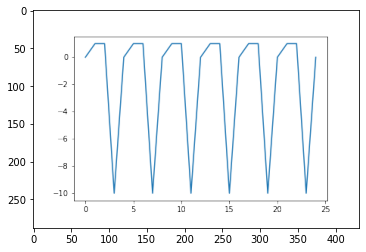

In [97]:
import io
io_buf = io.BytesIO()
fig.savefig(io_buf, format='raw', dpi=fig.dpi)
io_buf.seek(0)
img_arr = np.frombuffer(io_buf.getvalue(), dtype=np.uint8).reshape((int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
io_buf.close()
plt.imshow(img_arr)
img_arr.shape

In [82]:
newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1)

In [83]:
newshape

(288, 432, -1)

In [94]:
497664/288/432

4.0

In [85]:
img_arr.shape

(8640000,)

In [87]:
fig.bbox.bounds

(0.0, 0.0, 432.0, 288.0)

In [92]:
fig.dpi

72.0